# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
import seaborn as sns
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.metrics import mean_squared_error


# Get data

In [2]:
# set working directory
working_directory = "C:/Thesis/Codes/SoVI/developing_python/1_InputData"
os.chdir(working_directory)

1. BBGA

In [4]:
# load BBGA data
BBGA_data = pd.read_excel('2024_BBGA.xlsx',sheet_name="indicatoren")
# print(BBGA_data.head())

# select only social vulnerablity data from BBGA
sovi_codes = pd.read_excel("SoVI_code.xlsx",sheet_name="sovi")
filtered_codes_2021 = sovi_codes[(sovi_codes['Data source'] == 'BBGA') & (sovi_codes['Year'] == 2021)]
filtered_codes_2022 = sovi_codes[(sovi_codes['Data source'] == 'BBGA') & (sovi_codes['Year'] == 2022)]
bbga_codes_2021 =  ["gebiedcode22"] + filtered_codes_2021['Code'].tolist()
bbga_codes_2022 = ["niveaunaam", "gebiedcode22", "gebiednaam"] + filtered_codes_2022['Code'].tolist()
bbga_data_2021 = BBGA_data.loc[BBGA_data['jaar'] == 2021, bbga_codes_2021]
bbga_data_2022 = BBGA_data.loc[BBGA_data['jaar'] == 2022, bbga_codes_2022]

# finalize bbga datasets
bbga_data = pd.merge(
    bbga_data_2022,
    bbga_data_2021,
    on="gebiedcode22",
    how="left"
)
bbga_data = bbga_data[bbga_data['niveaunaam'] == 'Buurt']

2. CBS

In [5]:
# load CBS data
CBS_data = pd.read_excel('kwb_2022.xlsx')
# print(CBS_data.head())

# select only social vulnerablity data from CBS
filtered_codes_cbs = sovi_codes[(sovi_codes['Data source'] == 'CBS')]
cbs_codes =  ["regio"] + filtered_codes_cbs['Code'].tolist()
cbs_codes_numeric = filtered_codes_cbs['Code'].tolist()

# finalize cbs datasets
cbs_data = CBS_data[cbs_codes]

# replace '.' with np.nan and convert it into numeric
cbs_data.replace('.', np.nan, inplace=True)
cbs_data[cbs_codes_numeric] = cbs_data[cbs_codes_numeric].apply(pd.to_numeric, errors='coerce')

C:\Users\younmlink\AppData\Local\Temp\ipykernel_9884\865650572.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbs_data.replace('.', np.nan, inplace=True)
C:\Users\younmlink\AppData\Local\Temp\ipykernel_9884\865650572.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbs_data[cbs_codes_numeric] = cbs_data[cbs_codes_numeric].apply(pd.to_numeric, errors='coerce')


3. RIVM

In [6]:
# load RIVM data
rivm_data = []
rivm_path = 'RIVM/*.csv'
for file in glob.glob(rivm_path):
    rivm_code = pd.read_csv(file)
    rivm_code = rivm_code.iloc[:, [0,1]]
    rivm_file_name = os.path.splitext(os.path.basename(file))[0]
    rivm_code.rename(columns={rivm_code.columns[1]: rivm_file_name}, inplace=True)
    rivm_data.append(rivm_code)
rivm_data = pd.concat(rivm_data, axis=1)
rivm_data = rivm_data.loc[:,~rivm_data.columns.duplicated()]
rivm_data.rename(columns={rivm_code.columns[0]:"gebiednaam"}, inplace=True)
rivm_data = rivm_data.reset_index(drop=True)

4. Combine datasets

In [ ]:
# merge rivm and cbs data
rivm_data = rivm_data.merge(cbs_data, left_on='gebiednaam',right_on='regio', how='outer')

In [40]:
# load the match list
match_list = pd.read_csv('match_list.csv')

# merge match list with bbga_data and rivm_data
bbga_data_merged = bbga_data.merge(match_list, left_on='gebiednaam', right_on='Buurt', how='outer')
rivm_data_merged = rivm_data.merge(match_list, left_on='gebiednaam', right_on='buurtnaam', how='outer')

# merge bbga_data and rivm_data using the match list key
sovi_data = bbga_data_merged.merge(rivm_data_merged, on='Buurt', how='outer')
sovi_data = sovi_data.drop_duplicates(subset=['gebiednaam_x','BEVTOTAAL'], keep='first')

# drop unnecessary matchlist columns
sovi_data  = sovi_data.drop(columns=['Buurt', 'gebiednaam_y', 'buurtnaam_x', 'buurtnaam_y'])

# check the dropped rows
merged_df = pd.merge(bbga_data, sovi_data, left_on='gebiednaam', right_on='gebiednaam_x', how='outer', indicator=True)
dropped_rows = merged_df[merged_df['_merge'] == 'left_only']

# Data handling

1. Missing value treatment and data transformation

In [ ]:
# missing value treatment
sovi_data.isna().sum()

niveaunaam                               0
gebiedcode22                             0
gebiednaam_x                             0
BEVTOTAAL                               44
BEV0_4                                  89
BEV5_9                                  89
BEV10_14                                89
BEV65PLUS_P                             56
BEVMIGEUROP_P                           89
BEVMIGGEEN_P                            89
BEVVROUW_P                              56
BEVGEB                                  93
BEVEENOUDERHH_P                         63
BEVALLEENHH_P                           89
WCORHUUR_P                              83
WPARTHUUR_P                             83
WWOZ_GEM                               121
W_KRAP_P                                92
PUITKERING_1874_P                      125
IHHINK_GEM                             126
IWW_P                                  198
WCONTACTB_R                            188
WZBUURTHUIZEN_R                        217
LTHUISVOELE

In [42]:
sovi_data = sovi_data.dropna(subset=['BEV65PLUS_P']) 
sovi_data = sovi_data.dropna(subset=['BEVTOTAAL']) 
sovi_data = sovi_data[~(sovi_data['BEVTOTAAL'] <= 10)]  
sovi_data.isna().sum()

niveaunaam                               0
gebiedcode22                             0
gebiednaam_x                             0
BEVTOTAAL                                0
BEV0_4                                  22
BEV5_9                                  22
BEV10_14                                22
BEV65PLUS_P                              0
BEVMIGEUROP_P                           22
BEVMIGGEEN_P                            22
BEVVROUW_P                               0
BEVGEB                                  46
BEVEENOUDERHH_P                          1
BEVALLEENHH_P                           22
WCORHUUR_P                              20
WPARTHUUR_P                             20
WWOZ_GEM                                54
W_KRAP_P                                25
PUITKERING_1874_P                       58
IHHINK_GEM                              59
IWW_P                                  131
WCONTACTB_R                            121
WZBUURTHUIZEN_R                        150
LTHUISVOELE

In [43]:
# drop buurt containing 0 population
sovi_data.drop(columns=['niveaunaam', 'gebiedcode22','regio'], inplace=True)

# percentage of people registered in Amsterdam age 0-14
sovi_data['BEV0_14_P'] = (((sovi_data['BEV0_4'] + sovi_data['BEV5_9'] + sovi_data['BEV10_14']) / sovi_data['BEVTOTAAL'])*100).round(1)
sovi_data.drop(columns=['BEV0_4', 'BEV5_9', 'BEV10_14'], inplace=True)

# percentage of births during one year by mothers who are registered in Amsterdam
sovi_data['BEVGEB_P'] = ((sovi_data['BEVGEB'] / sovi_data['BEVTOTAAL'])*100).round(1)
sovi_data.drop(columns=['BEVGEB'], inplace=True)

# # percentage of migrants from Turkey, Morocco and Surinam
# sovi_data['BEVMIGTMS_P'] = sovi_data['BEVMIGTURK_P'] + sovi_data['BEVMIGMAROK_P'] + sovi_data['BEVMIGSUR_P']
# sovi_data.drop(columns=['BEVMIGTURK_P', 'BEVMIGMAROK_P', 'BEVMIGSUR_P'], inplace=True)

# percentage of non-western background
sovi_data['BEVMIG_P'] = (100 - (sovi_data['BEVMIGGEEN_P']+ sovi_data['BEVMIGEUROP_P'])).round(1)
sovi_data.drop(columns=['BEVMIGGEEN_P'], inplace=True)


# percentage of low-educated
sovi_data['a_opl_lg'] = ((sovi_data['a_opl_lg'] / sovi_data['BEVTOTAAL'])*100).round(1)
# sovi_data.drop(columns=['a_opl_lg'], inplace=True)

# # percentage of high-educated
# sovi_data['a_opl_hg'] = ((sovi_data['a_opl_hg'] / sovi_data['BEVTOTAAL'])*100).round(1)
# # sovi_data.drop(columns=['a_opl_hg'], inplace=True)

# # percentage of renter
# sovi_data['WHUUR_P'] = sovi_data['WCORHUUR_P'] + sovi_data['WPARTHUUR_P']
# sovi_data.drop(columns=['WPARTHUUR_P'], inplace=True)

# # number of points of sale per area and number of activities in the area as registered in the Jekuntmeer-database per 1,000 inhabitants
# sovi_data['BHLOCVKPDET_1000INW'] = ((sovi_data['BHLOCVKPDET'] / sovi_data['BEVTOTAAL'])* 1000).round(0)
# sovi_data['SKACTI_1000INW'] = ((sovi_data['SKACTI'] / sovi_data['BEVTOTAAL'])* 1000).round(0)
# sovi_data.drop(columns=['BHLOCVKPDET', 'SKACTI'], inplace=True)

# # cap extreme values of transformed values at the 99th percentile
# threshold = sovi_data['BHLOCVKPDET_1000INW'].quantile(0.99)
# sovi_data['BHLOCVKPDET_1000INW'] = sovi_data['BHLOCVKPDET_1000INW'].clip(upper=threshold)
# threshold = sovi_data['SKACTI_1000INW'].quantile(0.90)
# sovi_data['SKACTI_1000INW'] = sovi_data['SKACTI_1000INW'].clip(upper=threshold)

# fill missing values with mean value
def fill_with_mean_and_round(col):
    if col.dtype == 'int64' or (col.dropna().apply(float.is_integer).all()):
        mean_value = round(col.mean())
    else:
        mean_value = col.mean()
        decimals = str(col.dropna().iloc[0]).split('.')[-1] if col.dropna().any() else 0
        mean_value = round(mean_value, len(decimals))

    return col.fillna(mean_value)

sovi_data.iloc[:, 2:] =sovi_data.iloc[:, 2:].apply(fill_with_mean_and_round)

sovi_data.to_csv("sovi_data_transformed.csv", index=False)

2. Verify data accuracy

In [ ]:
# verify data accuracy
descriptive_stats = sovi_data.describe().transpose()

descriptive_stats['min'] = descriptive_stats['min']
descriptive_stats['max'] = descriptive_stats['max']
descriptive_stats['mean'] = descriptive_stats['mean']
descriptive_stats['std'] = descriptive_stats['std']

print(descriptive_stats[['min', 'max', 'mean', 'std']])

                                         min        max           mean  \
BEVTOTAAL                               11.0     6207.0    1950.955752   
BEV65PLUS_P                              0.0       50.0      13.444469   
BEVMIGEUROP_P                            1.4       66.0      16.828540   
BEVVROUW_P                              13.5       60.0      49.015929   
BEVEENOUDERHH_P                          0.0       25.5       7.500000   
BEVALLEENHH_P                            5.1       90.0      52.933407   
WCORHUUR_P                               0.0      100.0      34.688717   
WPARTHUUR_P                              0.0      100.0      32.631637   
WWOZ_GEM                             49636.0  2221653.0  475170.794248   
W_KRAP_P                                 0.0       90.0       9.942257   
PUITKERING_1874_P                        1.0       84.0      12.382743   
IHHINK_GEM                           19400.0   234500.0   51882.384956   
IWW_P                                 

# Index construction

1. Descriptive statistics

In [ ]:
# descriptive statistics
for variable, indicator in zip(sovi_codes['Code'], sovi_codes['Indicator relationship']):
    if indicator == -1:
        sovi_data[variable] = sovi_data[variable] * -1

In [46]:
sovi_data_cor = sovi_data.drop(columns=['gebiednaam_x','BEVTOTAAL','WWOZ_GEM','IHHINK_GEM','W_KRAP_P','IWW_P'])
# ,'W_KRAP_P','BEVMIGEUROP_P','p_arb_pp''PUITKERING_1874_P'

# function to calculate Cronbach’s alpha
def cronbach_alpha(df):
    items = df.shape[1]
    variances = df.var(ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    return items / (items - 1) * (1 - variances.sum() / total_variance)

# KMO Test
kmo_all, kmo_model = calculate_kmo(sovi_data_cor)
print(f"KMO Score: {kmo_model}")

# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(sovi_data_cor)
print(f"Bartlett’s Test: chi-square = {chi_square_value}, p-value = {p_value}")

# Cronbach's Alpha
alpha = cronbach_alpha(sovi_data_cor)
print(f"Cronbach’s Alpha: {alpha}")

if p_value < 0.001:
    print("Bartlett's Test p-value is below 0.001, suitable for PCA.")
else:
    print(f"Bartlett's Test p-value is {p_value}, which is above 0.001. Consider adjusting your dataset.")


KMO Score: 0.8657521959817873
Bartlett’s Test: chi-square = 15782.975670774249, p-value = 0.0
Cronbach’s Alpha: 0.874307484138962
Bartlett's Test p-value is below 0.001, suitable for PCA.


In [47]:
for variable, indicator in zip(sovi_codes['Code'], sovi_codes['Indicator relationship']):
    if indicator == -1:
        sovi_data[variable] = sovi_data[variable] * -1

2. indicators correlation

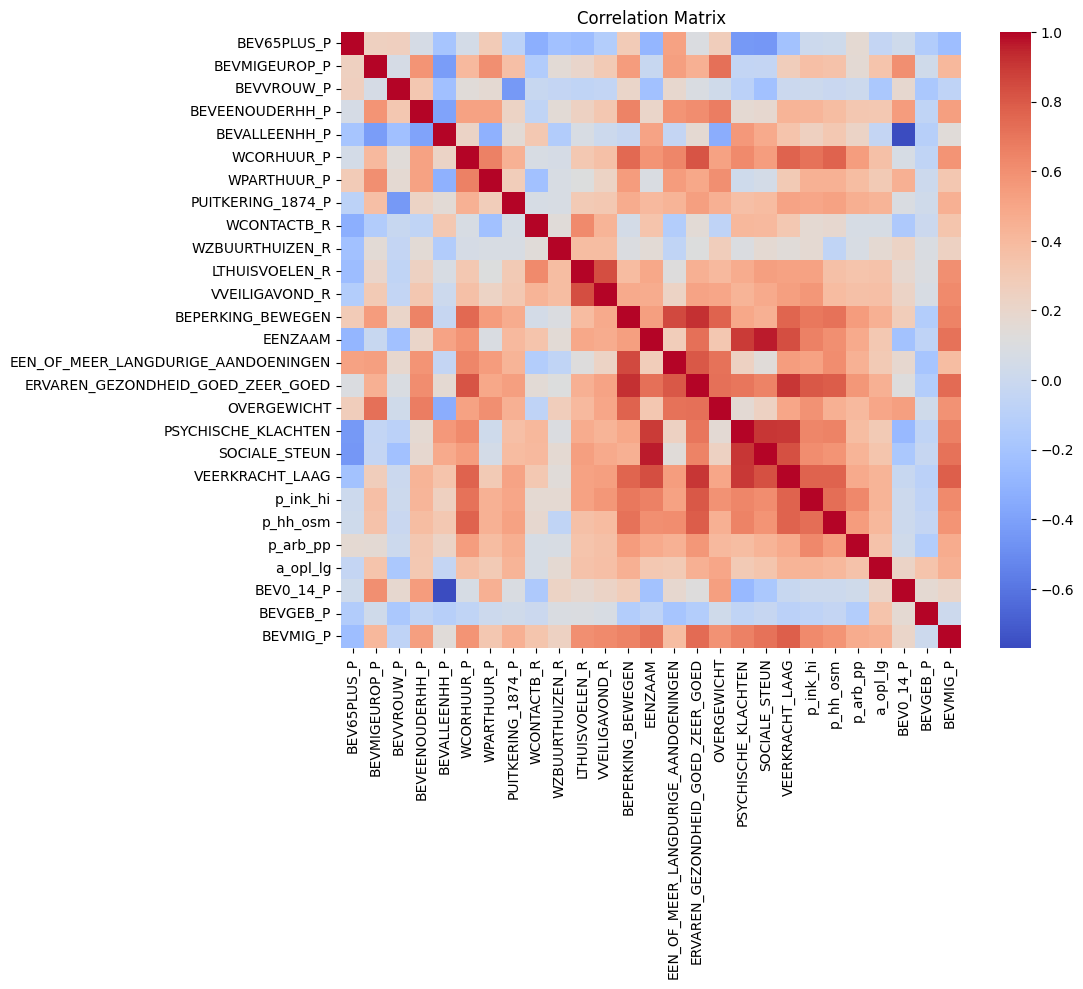

In [48]:
# calculate the correlation matrix and round to 2 decimal places
indicator_correlation = sovi_data_cor.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(indicator_correlation,  annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# export the correlation table to a CSV file
indicator_correlation.to_csv("indicator_correlation.csv", index=True)


3. Principal component analysis

In [ ]:
# principal component analysis
# step 1: standardize the data (mean = 0, variance = 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sovi_data_cor)

# step 2: perform PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# step 3: view explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# step 4: combine principal components into a dataframe
pca_result = pd.DataFrame(
    principal_components,
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])]
)
print(pca_result.head())


Explained Variance Ratio: [3.99841526e-01 1.69340931e-01 9.40044340e-02 5.92527546e-02
 4.21544320e-02 3.63293900e-02 3.02479729e-02 2.56613628e-02
 2.28433112e-02 1.87669920e-02 1.52715163e-02 1.38651841e-02
 1.30662433e-02 1.05747066e-02 9.33743068e-03 8.54513123e-03
 5.64014767e-03 5.59397237e-03 4.27822154e-03 4.12002405e-03
 3.45549694e-03 2.94594867e-03 2.02208459e-03 1.44878790e-03
 5.72757159e-04 5.28629635e-04 2.90611214e-04]
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.488345  2.211443 -1.077789  0.081607 -0.185517  0.483278  0.248396   
1 -1.471890 -0.526096 -2.524622  0.113983 -0.186016  0.050045  0.333949   
2 -1.987992 -1.598240 -1.171761 -0.381808 -0.283136 -0.397067  0.685173   
3  3.076086  0.560204 -1.938440 -1.594365  0.205695  1.824092  0.360283   
4 -0.838309  0.139782 -2.425771 -0.422752 -0.227454  0.028749 -0.495687   

        PC8       PC9      PC10  ...      PC18      PC19      PC20      PC21  \
0 -0.302018 -1.520248 -0.24812

4. Varimax rotation and Kaiser criteroin

Components with eigenvalue > 1 (Kaiser Criterion): [0 1 2 3 4]


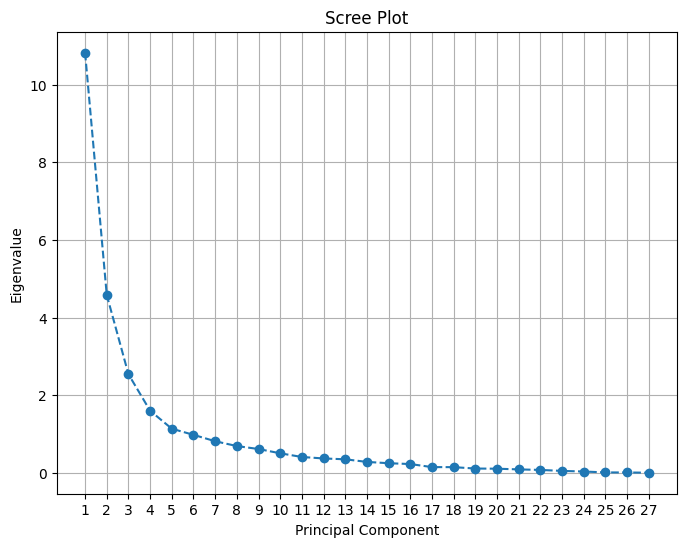

Explained Variance by Factors: (array([9.08649482, 4.55284529, 2.89762495, 1.841216  , 2.26585828]), array([0.33653685, 0.1686239 , 0.10731944, 0.06819319, 0.08392068]), array([0.33653685, 0.50516074, 0.61248019, 0.68067337, 0.76459405]))
Rotated Factor Loadings (Varimax Rotation):
[[-0.14541299  0.14934815 -0.20947846 -0.16925789  0.85806919]
 [ 0.20930365  0.74754179  0.05816886  0.15916498  0.27273241]
 [-0.00566082  0.28469755 -0.00970157 -0.81065779  0.07875993]
 [ 0.42989605  0.73915841  0.06175012 -0.19384345  0.01287452]
 [ 0.44846713 -0.79585359 -0.00708494  0.05513971  0.01329293]
 [ 0.83820019  0.25147126 -0.02889495 -0.04301533  0.15627086]
 [ 0.3552477   0.63345083 -0.11512648  0.028883    0.30107985]
 [ 0.50849056  0.10261124  0.05897223  0.60482619  0.22712524]
 [ 0.18128859 -0.30988621  0.7035626  -0.1044734  -0.13038335]
 [-0.01713537  0.24755856  0.55278946  0.09721329 -0.15774202]
 [ 0.34704948  0.08556477  0.86386382  0.1002887   0.00666353]
 [ 0.3687757   0.1927141

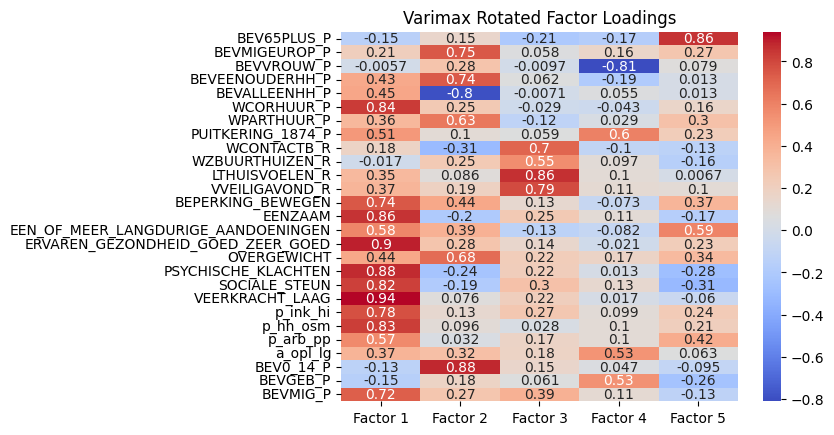

In [50]:
# Kaiser criterion (Eigenvalue > 1 for component retention
eigenvalues = pca.explained_variance_

# applying Kaiser criterion
kaiser_criterion = np.where(eigenvalues > 1)[0] 
print("Components with eigenvalue > 1 (Kaiser Criterion):", kaiser_criterion)

# scree Plot to visualize Eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues)+1))
plt.grid(True)
plt.show()

# perform Varimax rotation
fa = FactorAnalyzer(rotation="varimax", method="principal", n_factors=len(kaiser_criterion))
fa.fit(scaled_data)

# get rotated components
rotated_factors = fa.loadings_

# check the explained variance (similar to PCA explained variance)
explained_variance = fa.get_factor_variance()

# Print results
print("Explained Variance by Factors:", explained_variance)
print("Rotated Factor Loadings (Varimax Rotation):")
print(rotated_factors)

# visualize the rotated factor loadings
sns.heatmap(rotated_factors, annot=True, cmap='coolwarm', yticklabels=sovi_data_cor.columns, xticklabels=[f"Factor {i+1}" for i in range(len(kaiser_criterion))])
plt.title('Varimax Rotated Factor Loadings')
plt.show()

5. Calculate social vulnerability index

In [17]:
# get the factor/component scores (which are the values projected onto the factor axes)
component_scores = fa.transform(scaled_data)
pc_df = pd.DataFrame(component_scores, columns=[f"Factor_{i+1}" for i in range(component_scores.shape[1])])

# additive model
# caculate proportion of variance of each factor
explained_variance = pd.DataFrame(explained_variance)
variance_explained = explained_variance.div(explained_variance.sum(1),axis=0).loc[1,:].values.tolist()

# apply the cardinality adjustment to Factor 3 (flip the sign)
pc_df['Factor_3'] = pc_df['Factor_3'] * -1

# caculate sovi score
so_vi_score = (pc_df * variance_explained).sum(axis=1)

# add sovi score to the original data
sovi_output = pc_df.copy()
sovi_output['SoVI'] = so_vi_score
sovi_output.insert(0, 'gebiednaam_x', sovi_data['gebiednaam_x'].values)

# save the updated dataset with sovi scores
sovi_output.to_csv("SoVI_with_scores.csv", index=False)


End